In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



In [4]:

df = pd.read_parquet("../../datasets/amazon_user_reviews_text_sentiment.parquet")

# Ensure correct columns
texts = df["text_cleaned"].astype(str).values
labels = df["sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

max_vocab_size = 20000
max_length = 100

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post")


model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_length, mask_zero=True),
    SimpleRNN(128),
    Dense(64, activation="relu"),
    Dense(3, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.4080 - loss: 1.0748 - val_accuracy: 0.5774 - val_loss: 0.8835
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.6825 - loss: 0.7167 - val_accuracy: 0.5890 - val_loss: 0.8906
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.8687 - loss: 0.3623 - val_accuracy: 0.5693 - val_loss: 1.1619
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9538 - loss: 0.1388 - val_accuracy: 0.5414 - val_loss: 1.5850
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
MODEL EVALUATION METRICS
Accuracy:  0.5633
Precision: 0.5474
Recall:    0.5633
F1-Score:  0.5409

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1243
           1       0.45      0.25      0.32      1209
           2       0.53      0.72      0.61      1228

    accuracy                           0.56      3680
   macro avg       0.55      0.56      0.54      3680
weighted avg       0.55      0.56      0.54      3680

ROC=AUC REPORT
AUC score: 0.757833758414706


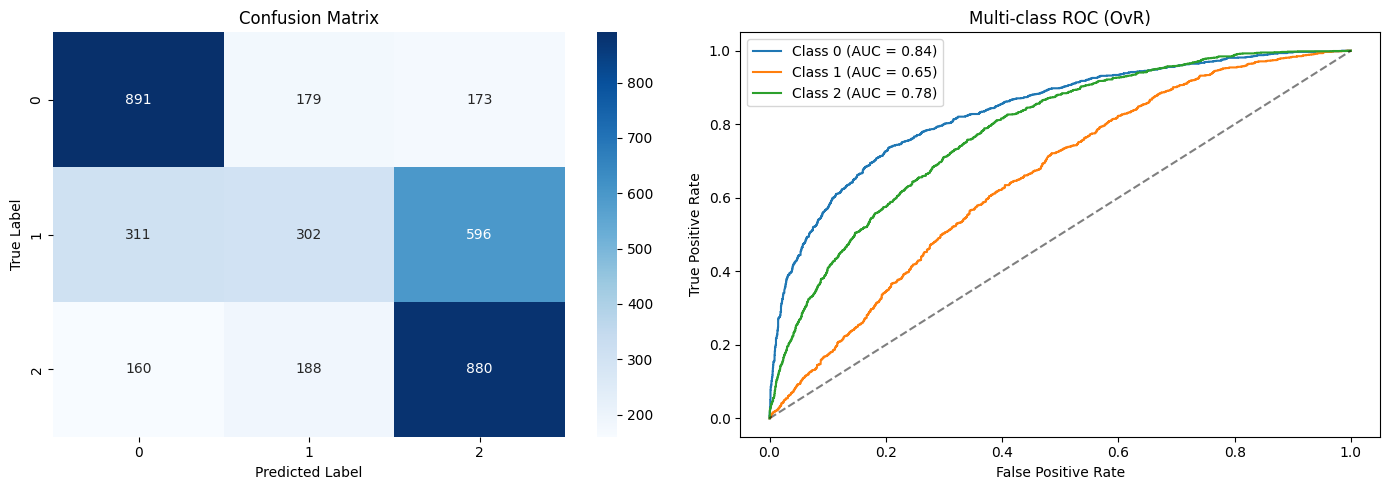

In [5]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../'))

# ModelEvaluation
from ModelEvaluation.ModelEvaluation import ModelEvaluation
# Model Evaluation

preds = model.predict(X_test_pad)
y_pred = np.argmax(preds, axis=1)
evaluator = ModelEvaluation()
evaluator.run_pipeline(y_test, y_pred, preds)